# CNN简介
CNN是计算机视觉领域几乎都在使用的一种深度学习模型，譬如将卷积神经网络应用于图像分类问题。一般在CNN结构里，一个卷积层由conv+batchnorm+activation三部分构成

图像卷积操作，和全连接层相比，它是部分连接的<a href="https://www.zhihu.com/question/52668301/answer/194998098">^</a>：
<img src="./DB/image/1.gif" style="zoom:0.6">
卷积核（上图中未画出）就相当于全连接中的权重矩阵，可以看到图像不同位置是共享同一权重的，这直接带来一个好处就是“平移不变性”，无论特征出现在图像的左上角、中间还是右下角，都能识别出来

Batch Normalization<a href="https://www.cnblogs.com/guoyaohua/p/8724433.html">^</a>：
<img src="./DB/image/2.png" style="zoom:0.8">
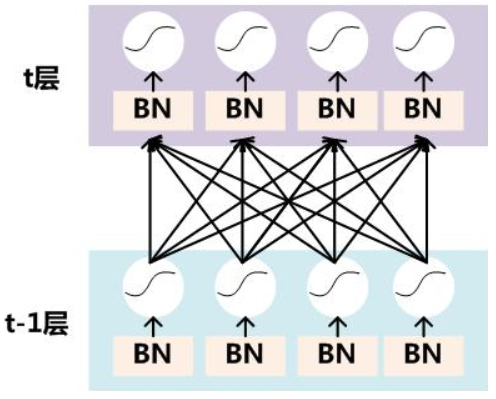
BN层是在线性激活之后，非线性激活之前

激活函数，通常采用ReLU<a href="https://www.cnblogs.com/adong7639/p/9213038.html">^</a>：
<img src="./DB/image/3.png" style="zoom:0.6">
普通的ReLU负数端斜率是0，Leaky ReLU则是负数端有一个比较小的斜率，而PReLU则是在后向传播中学习到斜率。而Randomized Leaky ReLU则是使用一个均匀分布在训练的时候随机生成斜率，在测试的时候使用均值斜率来计算

# 简单示例

关于GPU显存爆满的问题<a href="https://blog.csdn.net/MachineRandy/article/details/80040765">^</a>，解决：
```python
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf 
import keras.backend.tensorflow_backend as KTF
#进行配置，使用30%的GPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf.Session(config=config)

#设置session
KTF.set_session(session)
```
以上部分函数在tf 2.0中已被替换，具体请查看不同版本tensorflow函数对照<a href="https://docs.google.com/spreadsheets/d/1FLFJLzg7WNP6JHODX5q8BDgptKafq_slHpnHVbJIteQ/edit#gid=0">^</a>

In [1]:
#适用于tf 2.0版本
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #由于我只有一块GPU，因此这句话可以不用写，如果你有多块，因为keras默认占用所有GPU设备，因此
#需要具体指定使用哪一块，由此其他GPU设备将不再被占用，保持空闲

import tensorflow as tf
#进行配置，按需分配GPU显存
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)

#设置session
tf.compat.v1.keras.backend.set_session(session)

In [2]:
from keras import layers,models,optimizers

Using TensorFlow backend.


## 手写数字识别

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

上述代码设计了一个最简单的CNN结构，它是 Conv2D 层（卷积层）和 MaxPooling2D 层（池化层）的堆叠。`Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))`的第一个参数是卷积核的数量，第二个参数是卷积核的尺寸`(win_height,win_width)`，实际上卷积核并不一定是2D形状的，这取决于输入，譬如单通道图像输入，那么卷积核是二维的，如果三（多）通道图像输入，那么卷积核是3D形状`(win_height,win_width,input_depth)`，input_depth无需人为指定，激活函数采用ReLU，输入张量形状为(28, 28, 1)，因为我们的手写数字图像是单通道的，其中`28*28*1`的`1`就是input_depth

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


上面通过`summary()`方法打印了当前网络的基本信息，由于我们第一层采用了32个`3*3`的卷积核，默认的步长为1，因此输出的feature map尺寸为`26*26`，总计32张feature map，另外可以看到每个 Conv2D 层和 MaxPooling2D 层的输出都是一个形状为 (height, width, channels) 的 3D 张量，宽度和高度两个维度的尺寸通常会随着网络加深而变小。下一步是将最后的输出张量（大小为 (3, 3, 64) ）输入到一个密集连接分类器网络中，即一些堆叠的Dense层，但是分类器只接受1D向量，因此我们首先需要将输出的3D张量展平

In [10]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

现在导入训练数据：

In [5]:
from keras.datasets import mnist
from keras.utils import to_categorical

In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images.shape,train_labels.shape,test_images.shape,test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

编译和训练网络：

In [11]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 53s 889us/step - loss: 0.1746 - accuracy: 0.9445
Epoch 2/5
60000/60000 [==============================] - 54s 903us/step - loss: 0.0471 - accuracy: 0.9856
Epoch 3/5
60000/60000 [==============================] - 53s 884us/step - loss: 0.0324 - accuracy: 0.9901
Epoch 4/5
60000/60000 [==============================] - 52s 866us/step - loss: 0.0241 - accuracy: 0.9924
Epoch 5/5
60000/60000 [==============================] - 53s 879us/step - loss: 0.0189 - accuracy: 0.9947


In [8]:
model.save('./DB/data/mnist_7_conv1.h5')

In [3]:
model=models.load_model('./DB/data/mnist_7_conv1.h5')

在测试集上进行评估，可以发现无论是训练精度还是验证精度都比全连接网络要高：

In [14]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

10000/10000 [==============================] - 21s 2ms/step


0.9912999868392944

## 猫狗图片分类

数据集来自kaggle<a href="https://www.kaggle.com/c/dogs-vs-cats/data">^</a>包含两个文件夹，一个是test（总计12500张猫和狗的图），一个是train（25000张，其中有12500张猫图、12500张狗图），如下：
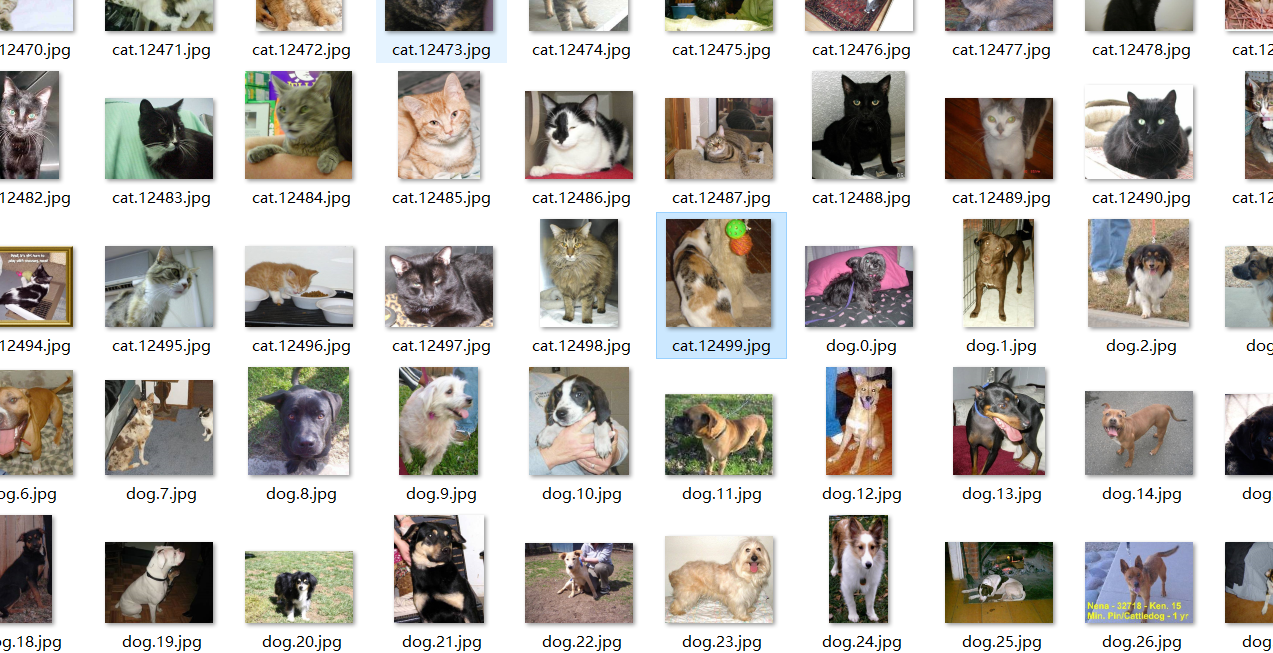
需要注意的是，它们的尺寸并非一致。为了减轻实验的压力，我们会使用较小的子集，直接从train目录中抽取1000张猫图作为训练集、再500张作为验证集、再500张作为测试集，同理狗也是如此

In [3]:
import os,shutil

In [9]:
origin_path=r'E:\flush\jupyter-notebook\DB\data\dogs-vs-cats\train' #train目录（原始数据）
parent_dir,_=os.path.split(origin_path)
new_path=os.path.join(parent_dir,'cats_and_dogs_small') #新的子数据集目录
#以下分别创建猫狗的训练、验证、测试数据存放的文件夹
train_dir=os.path.join(new_path,'train')
validation_dir=os.path.join(new_path,'validation')
test_dir=os.path.join(new_path,'test')
train_cat_dir=os.path.join(train_dir,'cats')
#os.makedirs(train_cat_dir)
train_dog_dir=os.path.join(train_dir,'dogs')
#os.makedirs(train_dog_dir)
validation_cat_dir=os.path.join(validation_dir,'cats')
#os.makedirs(validation_cat_dir)
validation_dog_dir=os.path.join(validation_dir,'dogs')
#os.makedirs(validation_dog_dir)
test_cat_dir=os.path.join(test_dir,'cats')
#os.makedirs(test_cat_dir)
test_dog_dir=os.path.join(test_dir,'dogs')
#os.makedirs(test_dog_dir)

In [ ]:
cats=['cat.{}.jpg'.format(i) for i in range(1000)] #将前 1000 张猫的图像复制到 train_cat_dir
for cat in cats:
    src = os.path.join(origin_path, cat)
    dst = os.path.join(train_cat_dir, cat)
    shutil.copyfile(src, dst)
cats=['cat.{}.jpg'.format(i) for i in range(1000,1500)] #将接下来500张复制到validation_cat_dir
for cat in cats:
    src = os.path.join(origin_path, cat)
    dst = os.path.join(validation_cat_dir, cat)
    shutil.copyfile(src, dst)
cats=['cat.{}.jpg'.format(i) for i in range(1500,2000)] #再将接下来500张复制到test_cat_dir
for cat in cats:
    src = os.path.join(origin_path, cat)
    dst = os.path.join(test_cat_dir, cat)
    shutil.copyfile(src, dst)
dogs=['dog.{}.jpg'.format(i) for i in range(1000)] #将前 1000 张狗的图像复制到 train_dog_dir
for dog in dogs:
    src = os.path.join(origin_path, dog)
    dst = os.path.join(train_dog_dir, dog)
    shutil.copyfile(src, dst)
dogs=['dog.{}.jpg'.format(i) for i in range(1000,1500)] #将接下来500张复制到validation_dog_dir
for dog in dogs:
    src = os.path.join(origin_path, dog)
    dst = os.path.join(validation_dog_dir, dog)
    shutil.copyfile(src, dst)
dogs=['dog.{}.jpg'.format(i) for i in range(1500,2000)] #再将接下来500张复制到test_dog_dir
for dog in dogs:
    src = os.path.join(origin_path, dog)
    dst = os.path.join(test_dog_dir, dog)
    shutil.copyfile(src, dst)

现在我们有 2000 张训练图像、1000 张验证图像和 1000 张测试图像。每个分组中两个类别的样本数相同，这是一个平衡的二分类问题，分类精度可作为衡量成功的指标

和上面的手写数字识别相比，这里要处理的是更大的图像和更复杂的问题，你需要相应地增大网络，譬如再增加一个 Conv2D + MaxPooling2D 的组合。这既可以增大网络容量，也可以进一步减小特征图的尺寸（但是特征图的个数在增加，因为一生二，二生三，三生无穷，底层特征就那么几个，但是它们却可以构成万事万物，其他所有的特征都由它们而来），使其在连接 Flatten 层时尺寸不会太大。本例中初始输入的尺寸设定为 150×150（有些随意的选择）。考虑到是一个二分类问题，所以网络最后一层是使用 sigmoid 激活的单一单元（大小为 1 的 Dense 层），这个单元将对某个类别的概率进行编码

In [29]:
model=models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

网络中特征图的深度在逐渐增大（从 32 增大到 128），而特征图的尺寸在逐渐减小（从150×150 减小到 7×7），这几乎是所有卷积神经网络的模式

In [30]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

在编译的时候，因为网络最后一层是单一 sigmoid 单元，所以我们将使用二元交叉熵作为损失函数，我们还尝试控制优化器的参数，也就是自定义了RMSprop的学习速率为le-4（0.001），其实这就是默认值

接下来的步骤就是给网络喂入训练数据了，在此之前，需要对数据进行预处理，我们知道，原始的图片甚至连尺寸都是各不相同的
- 读取图像文件
- 修改统一尺寸
- 转换为浮点数张量
- 将像素值（0~255 范围内）缩放到 [0, 1] 区间（正如你所知，神经网络喜欢处理较小的输入值）

Keras 拥有自动完成这些步骤的工具。Keras 有一个图像处理辅助工具的模块，位于 keras.preprocessing.image 。特别地，它包含 ImageDataGenerator 类，可以快速创建 Python 生成器，能够将硬盘上的图像文件自动转换为预处理好的张量批量

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255) #将所有图像乘以 1/255 缩放
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


我们定义了两个生成器对象，其中一个（train_generator）批量产生训练数据，一个（validation_generator）批量产生验证数据。两个生成器除了读取的图片路径不同外（这个路径有点意思，譬如在train_dir下面还有两个子目录，分别对应猫和狗的图片，上述代码的执行结果认为每一个子目录都是一个类别，这意味着它可以知道每张图片的标签是什么，0或者1，而无需再人为指定），其他参数一致（target_size参数将所有图像尺寸设置为`150*150`，class_mode参数用于设置标签，因为是二分类，所以使用二进制标签，batch_size参数表示每次批量产生的图像数量为20），看其中一个生成器的输出，它生成了 150×150 的 RGB 图像［形状为 (20, 150, 150, 3) ］与二进制标签［形状为 (20,) ］组成的批量。每个批量中包含 20 个样本（批量大小）

In [31]:
history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=30,validation_data=validation_generator,validation_steps=50)

Epoch 1/30
100/100 [==============================] - 3s 27ms/step - loss: 0.6855 - acc: 0.5410 - val_loss: 0.6855 - val_acc: 0.5120
Epoch 2/30
100/100 [==============================] - 2s 24ms/step - loss: 0.6458 - acc: 0.6280 - val_loss: 0.5429 - val_acc: 0.6590
Epoch 3/30
100/100 [==============================] - 2s 25ms/step - loss: 0.5885 - acc: 0.6840 - val_loss: 0.7737 - val_acc: 0.6300
Epoch 4/30
100/100 [==============================] - 3s 25ms/step - loss: 0.5573 - acc: 0.7240 - val_loss: 0.5271 - val_acc: 0.6630
Epoch 5/30
100/100 [==============================] - 2s 25ms/step - loss: 0.5289 - acc: 0.7315 - val_loss: 0.7247 - val_acc: 0.6680
Epoch 6/30
100/100 [==============================] - 2s 25ms/step - loss: 0.5047 - acc: 0.7525 - val_loss: 0.5598 - val_acc: 0.6850
Epoch 7/30
100/100 [==============================] - 3s 25ms/step - loss: 0.4737 - acc: 0.7700 - val_loss: 0.5162 - val_acc: 0.7020
Epoch 8/30
100/100 [==============================] - 2s 25ms/step - 

利用生成器，我们让模型对数据进行拟合。我们将使用 fit_generator 方法来拟合，它在数据生成器上的效果和 fit 相同。它的第一个参数应该是一个 Python 生成器，可以不停地生成输入和目标（标签）组成的批量，比如 train_generator 。因为数据是不断生成的，所以 Keras 模型要知道每一轮需要从生成器中抽取多少个样本。这是 steps_per_epoch 参数的作用：从生成器中抽取 steps_per_epoch 个批量后（即运行了 steps_per_epoch 次梯度下降），拟合过程将进入下一个轮次。本例中，每个批量包含 20 个样本，所以读取完所有 2000 个样本需要 100个批量。使用 fit_generator 时，你可以传入一个 validation_data 参数，其作用和在 fit 方法中类似。值得注意的是，这个参数可以是一个数据生成器，但也可以是 Numpy 数组组成的元组。如果向 validation_data 传入一个生成器，那么这个生成器应该能够不停地生成验证数据批量，因此你还需要指定 validation_steps 参数，说明需要从验证生成器中抽取多少个批次用于评估

和 fit 方法相比，fit_generator 能够帮助我们节省内存，这是鉴于生成器“惰性计算”的优势，只有当数据被需要时，才会计算它

In [5]:
import pickle

In [ ]:
#将训练历史保存下来
with open('./DB/data/cats_dogs_10_conv1_history.pickle','wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('./DB/data/cats_dogs_10_conv1_history.pickle','rb') as f:
    history=pickle.load(f)

In [34]:
model.save('./DB/data/cats_dogs_10_conv1.h5')

In [33]:
model=models.load_model('./DB/data/cats_dogs_10_conv1.h5')

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def plot_acc():
    history.history.keys()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

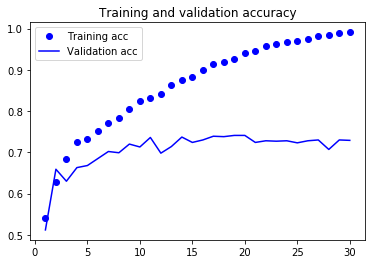

In [32]:
plot_acc()

In [8]:
def plot_loss():
    history.history.keys()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

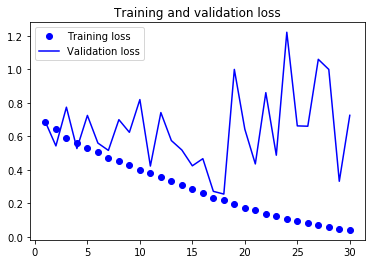

In [33]:
plot_loss()

从上述图像中仍能看出过拟合的特征（尽管卷积网络并非密集连接，即相对来说不易产生过拟合）。训练精度随着时间线性增加，直到接近 100%，而验证精度则停留在 70% 左右（目前我们的网络识别准确率还是比较低的）。验证损失在 13 轮左右达到最小值（相应的，验证精度此时也没有再增长。虽然变化幅度有点大，仍可以用一条光滑曲线去拟合变化趋势），然后保持不变，而训练损失则一直线性下降，直到接近于 0。因为训练样本相对较少（2000 个），所以过拟合是你最关心的问题。前面已经介绍过几种降低过拟合的技巧，比如 dropout 和权重衰减（L2 正则化）。现在我们将使用一种针对于计算机视觉领域的新方法，在用深度学习模型处理图像时几乎都会用到这种方法，它就是数据增强（data augmentation）

### 数据增强

过拟合的原因是学习样本太少，导致无法训练出能够泛化到新数据的模型。如果拥有无限的数据，那么模型能够观察到数据分布的所有内容，这样就永远不会过拟合。数据增强是从现有的训练样本中生成更多的训练数据，其方法是利用多种能够生成可信图像的随机变换来增加（augment）样本。其目标是，模型在训练时不会两次查看完全相同的图像（每一epoch，都不是完全一样的训练图片，都有所改变）。这让模型能够观察到数据的更多内容，从而具有更好的泛化能力

In [87]:
datagen = ImageDataGenerator(rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,
                             zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

在 Keras 中，可以通过对 ImageDataGenerator 实例读取的图像执行多次随机变换来实现，上述示例选用了几个参数，分别如下：
- rotation_range 是角度值（在 0~180 范围内），表示图像随机旋转的角度范围
- width_shift 和 height_shift 是图像在水平或垂直方向上平移的范围（相对于总宽度或总高度的比例）
- shear_range 是随机错切变换的角度
- zoom_range 是图像随机缩放的范围
- horizontal_flip 是随机将一半图像水平翻转。如果没有水平不对称的假设（比如真实世界的图像），这种做法是有意义的
- fill_mode 是用于填充新创建像素的方法，这些新像素可能来自于旋转或宽度/高度平移

In [53]:
from keras.preprocessing import image

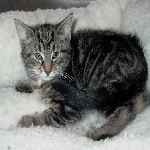

In [84]:
#实际操作一下，看看增强效果
cat_img_path = np.random.choice([os.path.join(train_cat_dir, fname) for fname in os.listdir(train_cat_dir)]) #随机选择一张猫图
cat_img = image.load_img(cat_img_path, target_size=(150, 150)) #读取图片并调整尺寸
cat_img

<Figure size 648x648 with 0 Axes>

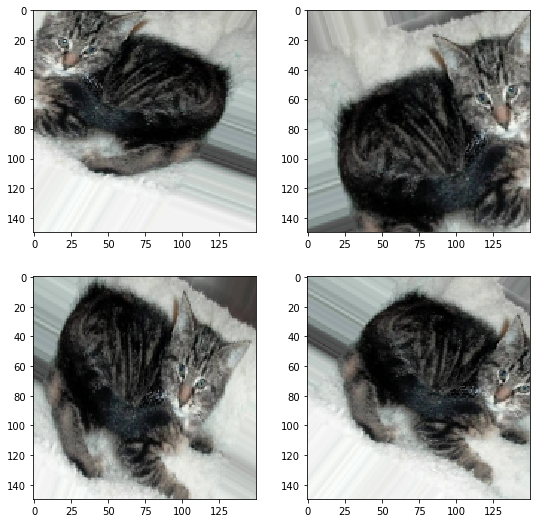

In [93]:
cat_img_array = image.img_to_array(cat_img) #将图像转为numpy数组，形状为(150,150,3)
cat_img_array = cat_img_array.reshape(1,*cat_img_array.shape) #将形状改变为(1,150,150,3)
i=0
plt.figure(figsize=(9,9))
for batch in datagen.flow(cat_img_array, batch_size=1):
    plt.subplot(221+i)
    plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0: #生成随机变换后的图像批量。循环是无限的，因此你需要在某个时刻终止循环
        break

如果你使用这种数据增强来训练一个新网络，那么网络将不会两次看到同样的输入。但络看到的输入仍然是高度相关的，因为这些输入都来自于少量的原始图像。你无法生成新信息，而只能混合现有信息。因此，这种方法可能不足以完全消除过拟合。为了进一步降低过拟合，你还可以向模型中添加一个 Dropout 层，添加到密集连接分类器之前（最初的Dropout是用于输入层或者是全连接层，目的就是为了防止由于数据量或者模型过大导致的过拟合问题，标准的Dropout一般是不会应用于卷积层的，另外“我们最近做输入是一维信号的CNN的时候也发现，在第一层卷积层加dropout确实提高了泛化能力，因为相当于在输入加入了噪声，但是要比较小心，小卷积核的时候用了反而效果变差了”），注意是用于密集层

下面给出完整的步骤：

In [94]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) #随机丢弃一半的节点，通常丢弃率控制在20%~50%比较好，可以从20%开始尝试。
#如果比例太低则起不到效果，比例太高则会导致模型的欠学习
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [95]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   zoom_range=0.2, horizontal_flip=True,) #对训练数据使用增强
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
validation_datagen = ImageDataGenerator(rescale=1./255) #但是不能对验证数据使用增强
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [96]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=validation_generator, validation_steps=50)
model.save('./DB/data/cats_dogs_11_conv2_dropout.h5')

Epoch 1/100
100/100 [==============================] - 15s 145ms/step - loss: 0.6942 - acc: 0.5157 - val_loss: 0.6837 - val_acc: 0.5761
Epoch 2/100
100/100 [==============================] - 13s 135ms/step - loss: 0.6854 - acc: 0.5483 - val_loss: 0.6899 - val_acc: 0.5084
Epoch 3/100
100/100 [==============================] - 13s 133ms/step - loss: 0.6735 - acc: 0.5830 - val_loss: 0.7824 - val_acc: 0.5393
Epoch 4/100
100/100 [==============================] - 14s 136ms/step - loss: 0.6618 - acc: 0.6067 - val_loss: 0.5972 - val_acc: 0.6456
Epoch 5/100
100/100 [==============================] - 13s 132ms/step - loss: 0.6445 - acc: 0.6200 - val_loss: 0.6498 - val_acc: 0.6701
Epoch 6/100
100/100 [==============================] - 14s 142ms/step - loss: 0.6288 - acc: 0.6427 - val_loss: 0.5987 - val_acc: 0.6501
Epoch 7/100
100/100 [==============================] - 13s 134ms/step - loss: 0.6222 - acc: 0.6413 - val_loss: 0.6144 - val_acc: 0.6859
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 14s 135ms/step - loss: 0.4178 - acc: 0.8021 - val_loss: 0.3931 - val_acc: 0.7880
Epoch 62/100
100/100 [==============================] - 13s 133ms/step - loss: 0.4143 - acc: 0.8141 - val_loss: 0.5900 - val_acc: 0.8135
Epoch 63/100
100/100 [==============================] - 14s 138ms/step - loss: 0.3978 - acc: 0.8134 - val_loss: 0.3899 - val_acc: 0.8177
Epoch 64/100
100/100 [==============================] - 13s 131ms/step - loss: 0.4063 - acc: 0.8078 - val_loss: 0.6163 - val_acc: 0.7448
Epoch 65/100
100/100 [==============================] - 13s 134ms/step - loss: 0.4082 - acc: 0.8093 - val_loss: 0.4908 - val_acc: 0.8242
Epoch 66/100
100/100 [==============================] - 13s 134ms/step - loss: 0.3961 - acc: 0.8220 - val_loss: 0.6817 - val_acc: 0.8112
Epoch 67/100
100/100 [==============================] - 13s 135ms/step - loss: 0.3905 - acc: 0.8273 - val_loss: 0.2668 - val_acc: 0.7944
Epoch 68/100
100/100 [===================

In [ ]:
model=models.load_model('./DB/data/cats_dogs_11_conv2_dropout.h5')

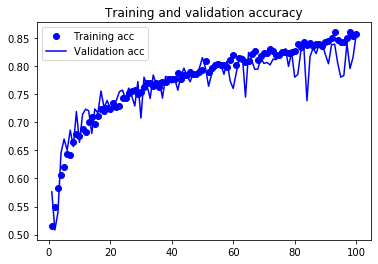

In [101]:
plot_acc()

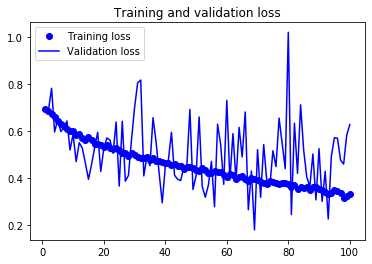

In [105]:
plot_loss()

## 预训练
想要将深度学习应用于小型图像数据集，一种常用且非常高效的方法是使用预训练网络。预训练网络（pretrained network）是一个保存好的网络，之前已在大型数据集（通常是大规模图像分类任务）上训练好。如果这个原始数据集足够大且足够通用，那么预训练网络学到的特征的空间层次结构可以有效地作为视觉世界的通用模型，因此这些特征可用于各种不同的计算机视觉问题，即使这些新问题涉及的类别和原始任务完全不同。举个例子，你在 ImageNet 上训练了一个网络（其类别主要是动物和日常用品），然后将这个训练好的网络应用于某个不相干的任务，比如在图像中识别家具。这种学到的特征在不同问题之间的可移植性，是深度学习与许多早期浅层学习方法相比的重要优势，它使得深度学习对小数据问题非常有效

使用预训练网络有两种方法：特征提取（feature extraction）和微调模型（fine-tuning），前者完全冻结预训练网络，仅仅视为一个现成的特征提取工具，无法更改该提取器的任何参数，后者则允许微调预训练的网络，毫无疑问，在计算机允许的情况下，后者总是优于前者，因为以不变应万变是愚蠢的

### 特征提取

特征提取是使用之前网络学到的表示来从新样本中提取出有趣的特征。然后将这些特征输入一个新的分类器，从头开始训练
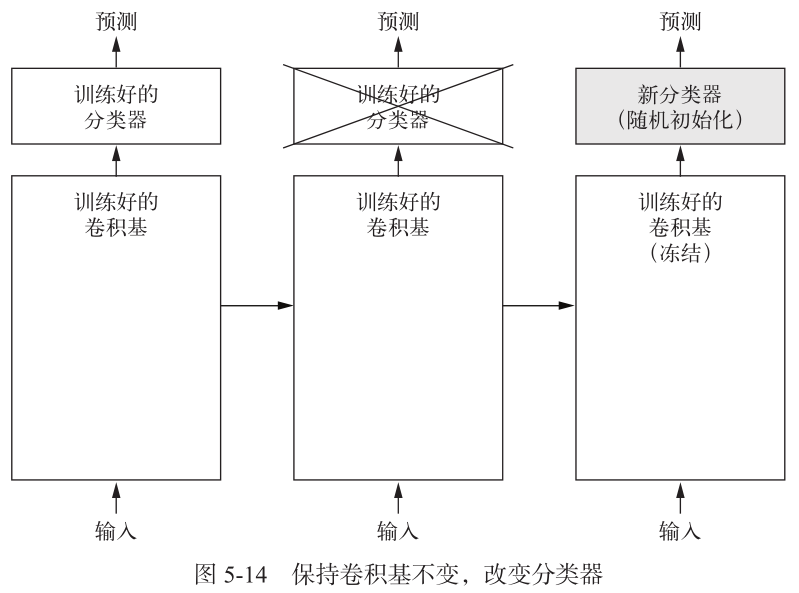
注意，某个卷积层提取的表示的通用性（以及可复用性）取决于该层在模型中的深度。模型中更靠近底部的层提取的是局部的、高度通用的特征图（比如视觉边缘、颜色和纹理），而更靠近顶部的层提取的是更加抽象的概念（比如“猫耳朵”或“狗眼睛”）。 a 因此，如果你的新数据集与原始模型训练的数据集有很大差异，那么最好只使用模型的前几层来做特征提取，而不是使用整个卷积基

本例中，假设有一个在 ImageNet 数据集（140 万张标记图像，1000 个不同的类别）上训练好的大型卷积神经网络。ImageNet 中包含许多动物类别，其中包括不同种类的猫和狗，因此可以认为它在猫狗分类问题上也能有良好的表现。下面我们来实践一下，使用在 ImageNet 上训练的 VGG16 网络的卷积基从猫狗图像中提取有趣的特征，然后在这些特征上训练一个猫狗分类器。VGG16 等模型内置于 Keras 中。你可以从 keras.applications 模块中导入

In [10]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

如果下载不下来，可以手动下载，然后放到user/administrator/.keras/models目录下面（Windows系统）。我们在将VGG16模型实例化的时候，传入了几个参数，weights参数有几个取值，如果取值None，表示随机初始化网络，如果取值imagenet，表示加载训练好的模型参数，它还可以是一个path路径指向权重文件的路径。include_top 指定模型最后是否包含密集连接分类器。默认情况下，这个密集连接分类器对应于 ImageNet 的 1000 个类别。因为我们打算使用自己的密集连接分类器（只有两个类别： cat 和 dog ），所以不需要包含它。input_shape 是输入到网络中的图像张量的形状。这个参数完全是可选的，如果不传
入这个参数，那么网络能够处理任意形状的输入

In [11]:
conv_base.summary() #VGG16 卷积基的详细架构如下所示。它和你已经熟悉的简单卷积神经网络很相似

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

最后的特征图形状为 (4, 4, 512) 。我们将在这个特征上添加一个密集连接分类器。接下来，下一步有两种方法可供选择：
- 在你的数据集上运行卷积基，将输出保存成硬盘中的 Numpy 数组，然后用这个数据作为输入，输入到独立的密集连接分类器中（简单来说就是，卷积基是一个已经训练完毕的优良的特征提取器，之后的工作就和我们一开始所使用的最简单的全连接神经网络类似，将提取好的特征输入该密集网络，训练得到一个分类器）。这种方法速度快，计算代价低，因为对于每个输入图像只需运行一次卷积基，而卷积基是目前流程中计算代价最高的。但出于同样的原因，这种方法不允许你使用数据增强
- 在顶部添加 Dense 层来扩展已有模型（即 conv_base ），并在输入数据上端到端地运行整个模型。这样你可以使用数据增强，因为每个输入图像进入模型时都会经过卷积基。但出于同样的原因，这种方法的计算代价比第一种要高很多

#### 不使用数据增强的快速特征提取

In [53]:
datagen = ImageDataGenerator(rescale=1./255) #这玩意儿仍将用于批量生产原始的图像训练数据或验证数据或测试数据，这依据实例化的时候
#所传入的路径参数不同而不同
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) #存放卷积基提取后的图像样本特征
    labels = np.zeros(sample_count) #存放样本标签
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary') #实例化数据生成器
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [54]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
np.savez('./DB/data/VGG16_dogs_cats_small_train_data.npz',train_features=train_features,train_labels=train_labels)
np.savez('./DB/data/VGG16_dogs_cats_small_validation_data.npz',validation_features=validation_features,validation_labels=validation_labels)
np.savez('./DB/data/VGG16_dogs_cats_small_test_data.npz',test_features=test_features,test_labels=test_labels)

In [55]:
#目前，提取的特征形状为 (samples, 4, 4, 512) ，要将其输入到密集连接分类器中，所以首先必须将其形状展平为 (samples, 8192)
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

下面我们定义一个密集连接分类器（注意要使用 dropout 正则化），并在刚刚保存的数据和标签上训练这个分类器：

In [12]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5)) #此处dropout层添加在第一个隐层后（且只有一个隐层），可以试着在输入层后面添加dropout层
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 266us/step - loss: 0.5783 - acc: 0.6910 - val_loss: 0.4441 - val_acc: 0.8470
Epoch 2/30
2000/2000 [==============================] - 0s 211us/step - loss: 0.4331 - acc: 0.8005 - val_loss: 0.3716 - val_acc: 0.8610
Epoch 3/30
2000/2000 [==============================] - 0s 214us/step - loss: 0.3728 - acc: 0.8520 - val_loss: 0.3335 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 0s 208us/step - loss: 0.3208 - acc: 0.8700 - val_loss: 0.3206 - val_acc: 0.8710
Epoch 5/30
2000/2000 [==============================] - 0s 208us/step - loss: 0.2960 - acc: 0.8745 - val_loss: 0.2923 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 0s 206us/step - loss: 0.2698 - acc: 0.8955 - val_loss: 0.2857 - val_acc: 0.8840
Epoch 7/30
2000/2000 [==============================] - 0s 210us/step - loss: 0.2471 - acc: 0.9040 - val_loss: 0.2740 - val_acc: 0.8850


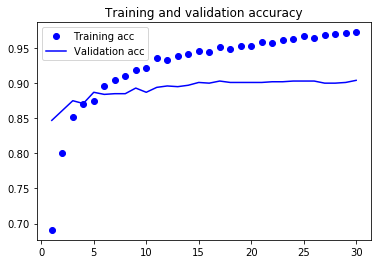

In [60]:
plot_acc()

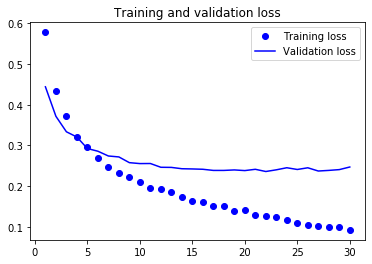

In [61]:
plot_loss()

可以看到我们的验证精度目前达到了90%，和之前使用了数据增强的模型相比，获得了比较大的提升。但从图中也可以看出，虽然 dropout 比率相当大，但模型几乎从一开始就过拟合。这是因为本方法没有使用数据增强，而数据增强对防止小型图像数据集的过拟合非常重要

#### 使用数据增强的特征提取
特征提取的第二种方法，它的速度比较慢，计算代价也较高（因为每一轮都将使用数据增强，增强后的图片都要经过VGG网络提取特征），但在训练期间可以使用数据增强。这种方法就是：扩展 conv_base 模型，然后在输入数据上端到端地运行模型

In [11]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


如你所见，VGG16 的卷积基有 14 714 688 个参数，非常多。在其上添加的分类器有 200 万个参数。在编译和训练模型之前，一定要“冻结”卷积基。冻结（freeze）一个或多个层是指在训练过程中保持其权重不变。如果不这么做，那么卷积基之前学到的表示将会在训练过程中被修改。因为其上添加的 Dense 层是随机初始化的，所以非常大的权重更新将会在网络中传播，对之前学到的表示造成很大破坏

在 Keras 中，冻结网络的方法是将其 trainable 属性设为 False

这里有一个奇怪的问题，按照书上的说法是需要冻结网络的，之后得到的训练结果精度可以达到96%，但是书上似乎弄错了，相反，只有不冻结才能达到96%（否则最终验证精度只有90%，而且验证精度比训练精度还要高，训练精度只有87%，且验证损失也比训练损失要低，这实在是超出我的理解，按道理说，确实是，模型的泛化能力应该更好一点，但是训练精度如此低是什么情况？在当前实验的基础之上，仅仅去掉数据增强，其他保持不变，仍冻结卷积基，最终训练精度达到了99.9%，验证精度为90%，我突然想起从前的事情，我是一个懦夫，一个绝对不配得到爱的人，我有时候很羡慕我的一些同学，他们尽管有点社会化，但是敢做敢为，我不认为那是无知，即便如此，我也希望自己能够无知一次），而且我在网上找了其他人的代码笔记，同样是没有冻结，训练时间上不冻结比冻结耗时更长，同时消耗极多的资源
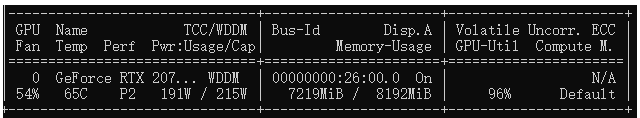
看起来我的显卡也就这样了

In [13]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


如此设置之后，只有添加的两个 Dense 层的权重才会被训练。总共有 4 个权重张量，每层 2 个（主权重矩阵和偏置向量）。注意，为了让这些修改生效，你必须执行编译模型的步骤，如果在编译之后修改了权重的 trainable 属性，那么应该重新编译模型，否则这些修改将被忽略

下面是和之前的数据增强示例一样的步骤，创建一个数据生成器，每一轮都能产生增强后的图片样本

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [15]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)

Epoch 1/30
100/100 [==============================] - 16s 156ms/step - loss: 0.5143 - acc: 0.7320 - val_loss: 0.2448 - val_acc: 0.9160
Epoch 2/30
100/100 [==============================] - 12s 119ms/step - loss: 0.2960 - acc: 0.8720 - val_loss: 0.3121 - val_acc: 0.9260
Epoch 3/30
100/100 [==============================] - 12s 119ms/step - loss: 0.2245 - acc: 0.9110 - val_loss: 0.0885 - val_acc: 0.9560
Epoch 4/30
100/100 [==============================] - 12s 119ms/step - loss: 0.1778 - acc: 0.9330 - val_loss: 0.1228 - val_acc: 0.8990
Epoch 5/30
100/100 [==============================] - 12s 120ms/step - loss: 0.1435 - acc: 0.9410 - val_loss: 0.0301 - val_acc: 0.9630
Epoch 6/30
100/100 [==============================] - 12s 120ms/step - loss: 0.1426 - acc: 0.9485 - val_loss: 0.2429 - val_acc: 0.9210
Epoch 7/30
100/100 [==============================] - 12s 120ms/step - loss: 0.1216 - acc: 0.9570 - val_loss: 0.0590 - val_acc: 0.9520
Epoch 8/30
100/100 [==============================] - 1

In [16]:
model.save('./DB/data/cats_dogs_conv3_vgg16.h5')

In [17]:
#将训练历史保存下来
with open('./DB/data/cats_dogs_conv3_vgg16_history.pickle','wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('./DB/data/cats_dogs_conv3_vgg16_history.pickle','rb') as f:
    history=pickle.load(f)

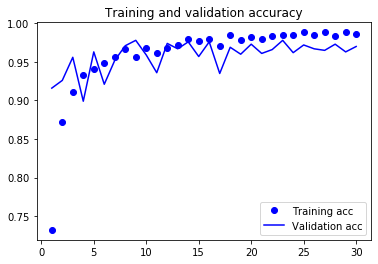

In [18]:
plot_acc()

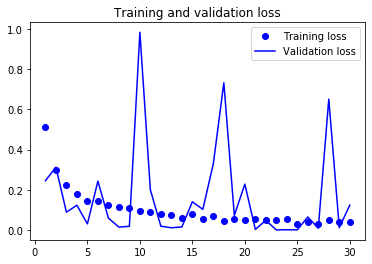

In [19]:
plot_loss()

完整的脚本见*./DB/使用数据增强和卷积基的特征提取.py*

### 微调模型
另一种广泛使用的模型复用方法是模型微调（fine-tuning），与特征提取互为补充。对于用于特征提取的冻结的模型基，微调是指将其顶部的几层“解冻”，并将这解冻的几层和新增加的部分（本例中是全连接分类器）联合训练。之所以叫作微调，是因为它只是略微调整了所复用模型中更加抽象的表示，以便让这些表示与手头的问题更加相关，而对于底层特征，由于它们足够“原子”，因此具有通用性，可以放心复用
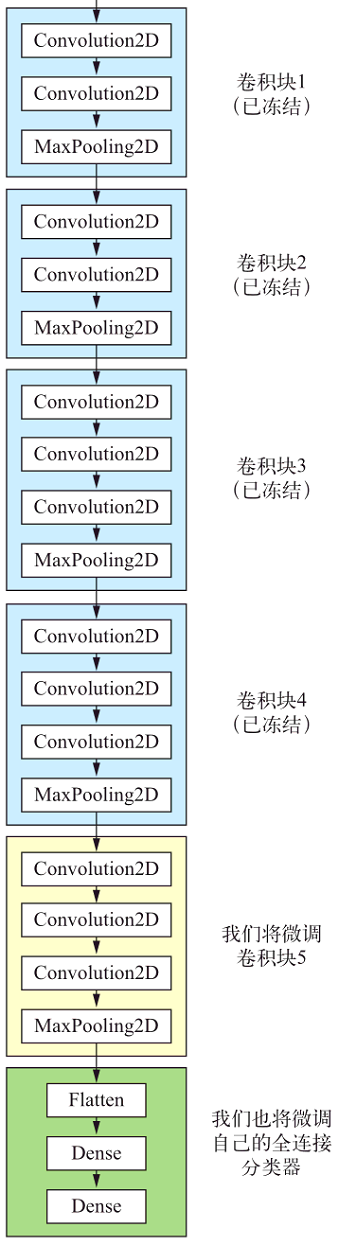
前面说过，冻结 VGG16 的卷积基是为了能够在上面训练一个随机初始化的分类器。同理，只有上面的分类器已经训练好了，才能微调卷积基的顶部几层。如果分类器没有训练好，那么训练期间通过网络传播的误差信号会特别大，微调的几层之前学到的表示都会被破坏。因此，微调网络的步骤如下：
- 在已经训练好的基网络（base network）上添加自定义网络
- 冻结基网络
- 训练所添加的部分
- 解冻基网络的一些层
- 联合训练解冻的这些层和添加的部分

为什么不微调更多层？为什么不微调整个卷积基？你当然可以这么做，但需要考虑以下几点：
- 卷积基中更靠底部的层编码的是更加通用的可复用特征，而更靠顶部的层编码的是更专业化的特征。微调这些更专业化的特征更加有用，因为它们需要在你的新问题上改变用途。微调更靠底部的层，得到的回报会更少
- 训练的参数越多，过拟合的风险越大。卷积基有 1500 万个参数，所以在你的小型数据集上训练这么多参数是有风险的。因此，在这种情况下，一个好策略是仅微调卷积基最后的两三层。我们从上一个例子结束的地方开始，继续实现此方法

讲道理，话说到这个份上，微调的模型效果应该比上面完全解冻的模型效果要好是吧？看下面的实验，实验接着上面一小节的代码，注意要先冻结训练密集网络之后，再解冻部分基网络，然后再进行联合训练，千万注意！

In [15]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50) #先冻结训练

Epoch 1/30
100/100 [==============================] - 12s 118ms/step - loss: 0.5942 - acc: 0.6995 - val_loss: 0.4926 - val_acc: 0.8100
Epoch 2/30
100/100 [==============================] - 10s 96ms/step - loss: 0.4892 - acc: 0.7750 - val_loss: 0.3644 - val_acc: 0.8560
Epoch 3/30
100/100 [==============================] - 9s 95ms/step - loss: 0.4304 - acc: 0.8125 - val_loss: 0.3138 - val_acc: 0.8500
Epoch 4/30
100/100 [==============================] - 9s 94ms/step - loss: 0.4078 - acc: 0.8155 - val_loss: 0.1642 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 10s 96ms/step - loss: 0.3873 - acc: 0.8235 - val_loss: 0.4732 - val_acc: 0.8880
Epoch 6/30
100/100 [==============================] - 9s 94ms/step - loss: 0.3716 - acc: 0.8375 - val_loss: 0.2828 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 9s 93ms/step - loss: 0.3529 - acc: 0.8465 - val_loss: 0.2966 - val_acc: 0.8920
Epoch 8/30
100/100 [==============================] - 10s 96ms/st

In [16]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers: #冻结直到某一层的所有层，反过来说就是，将某一层向后的所有层解冻
    if layer.name == 'block4_conv1': #原本书中是block5_conv1，这里我们解冻了更多的基，因为实际测试的时候发现，设置为block5_conv1的效果比较差
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

现在你可以开始微调网络。我们将使用学习率非常小的 RMSProp 优化器来实现。之所以让学习率很小，是因为对于微调的三层表示，我们希望其变化范围不要太大。太大的权重更新可能会破坏这些表示

In [17]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc']) #修改trainable属性后，需要重新编译
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50) #再联合训练

Epoch 1/30
100/100 [==============================] - 11s 106ms/step - loss: 0.2897 - acc: 0.8750 - val_loss: 0.3707 - val_acc: 0.9230
Epoch 2/30
100/100 [==============================] - 10s 96ms/step - loss: 0.2337 - acc: 0.9005 - val_loss: 0.1990 - val_acc: 0.9260
Epoch 3/30
100/100 [==============================] - 9s 95ms/step - loss: 0.2097 - acc: 0.9155 - val_loss: 0.3465 - val_acc: 0.9340
Epoch 4/30
100/100 [==============================] - 9s 94ms/step - loss: 0.1831 - acc: 0.9250 - val_loss: 0.0565 - val_acc: 0.9370
Epoch 5/30
100/100 [==============================] - 10s 96ms/step - loss: 0.1544 - acc: 0.9375 - val_loss: 0.2834 - val_acc: 0.9410
Epoch 6/30
100/100 [==============================] - 9s 94ms/step - loss: 0.1413 - acc: 0.9435 - val_loss: 0.2950 - val_acc: 0.9200
Epoch 7/30
100/100 [==============================] - 9s 94ms/step - loss: 0.1437 - acc: 0.9490 - val_loss: 0.3538 - val_acc: 0.9470
Epoch 8/30
100/100 [==============================] - 10s 96ms/st

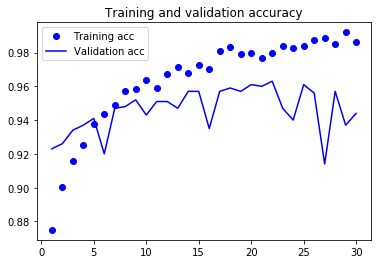

In [18]:
plot_acc()

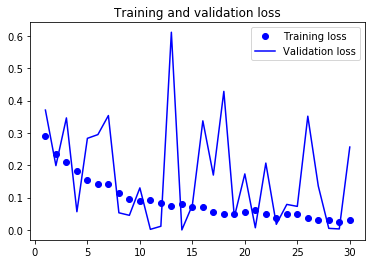

In [19]:
plot_loss()

下面是在完全解冻的情况下联合训练的结果，实际效果是要比上面的好上那么一丢丢的，尽管不是太看得出来：
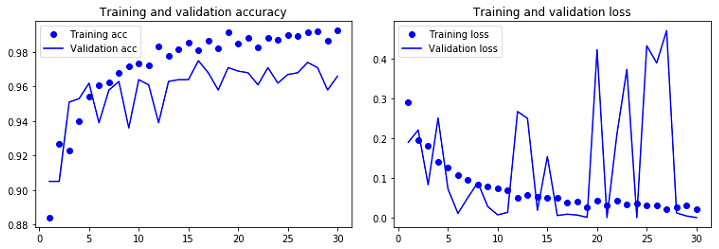

不管书上写得怎么样，这都是铁板铮铮的事实，那就是在这个实验上，先冻结训练密集二分网络后完全解冻联合训练卷积基+密集二分网络的效果是最好的，但是微调解冻卷积块4、5的结果和它也差不了多少，但是仅仅解冻卷积块5的结果就不如人意了，书上是坚持要“微”调的，而不建议完全解冻，但是它也并未指明“微”的程度，你可以根据实际情况或多或少的改变。看起来，VGG卷积基携带有庞大的参数，一旦全部解冻，意味着过拟合的风险非常大，但是实验结果并未证明这一点，因为有数据增强在撑腰，在这种情况下，如果再冻结很多参数，反而会获得一个比较差的效果，因此最终我的结论是，在一般情况下，也就是不使用诸如数据增强之类用于缓解过拟合的策略，那么“微调”模型仍是最佳选择，因为“微”调本身就可以缓解过拟合风险。另外不建议完全解冻是因为计算量将更大

参考：  
[1] https://zhuanlan.zhihu.com/p/31919653 CNN简介